# Importowanie bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import ppscore as pps
import networkx as nx
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway
from scipy.stats import kruskal
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import time
from scipy.stats import mannwhitneyu, kruskal
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from sklearn.utils import resample
import xgboost as xgb







pd.set_option('mode.chained_assignment', None)


# Wczytanie Danych

In [2]:
data = pd.read_csv('/home/krzysztof/Kaczmarek/Projket2/ICPSR_27521/DS0001/27521-0001-Data.tsv',sep='\t')

In [3]:
columns_to_check = [
    "DEPRESSIONINDEX", "DEP_EPISODE", "MDELastYr", "ANYTXRXMDE", 
    "CATAG2", "CATAG3", "CATAG7", "IRSEX", "NEWRACE2", "ANYINDEX", "YO_MDEA6",
    "MJANDCOKE", "ILLICITDRUGUSE", "LSYRILLICIT", "COKECRACK", "OTHERILLICIT", 
    "MARJLTYR", "MJCOKELY", "COCCRKLY", "MJGT12MO", "COCGT12MO", "ANYGT12MO", 
    "ALCFMFPB", "IREDUC2", "EDU_DUMMY", "INCOME", "INCOME_R", "POVERTY", 
    "IRPRVHLT", "WORKFORCE", "EMPSTAT4", "REVERSEPOP", "MOVESPY2", "CACHAR", 
    "CATYPE", "CRIMEHIST", "ANYSDRUG", "ANYATTACK", "ANYTHEFT", "NUMARREST", 
    "HEALTH2", "SCHDSICK", "SCHDSKIP", "TXLCAD", "DSTNCALM", "DSTTIRE", 
    "DSTSITST", "DSTDEPRS", "DSTCHEER", "DSTNRVOS", "YOWRSATP", "YOWRSPLN", 
    "ADWRDLOT", "ADWRSTHK", "YO_MDEA4", "ADWRSLEP", "ADWRSMOR", "YO_MDEA3", 
    "ADWRELES", "IRMARIT", "NOMARR2", "RKIDSHH", "MARRIED", "CHILDRENINHOME"
]

available_columns = [col for col in columns_to_check if col in data.columns]

df_filtered = data[available_columns]

# Rozkład danych w zmiennej DEPRESSIONINDEX

In [4]:

def plot_percentage_barplot(data,column_name):
    depression = data[column_name]
    if depression.isnull().sum() == 0:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        value_counts = depression.value_counts(dropna=False)
        labels = value_counts.index.to_series().fillna('Missing Data').astype(str)
        colors = plt.cm.Paired.colors[:len(value_counts)]
        
        axes[0].bar(labels, value_counts.values, color=colors) 
        axes[0].set_title(f'{column_name} - Bar Chart')
        axes[0].set_ylabel('Count')
        axes[0].set_xlabel(column_name)
        
        def autopct_format(pct):
            return f'{pct:.1f}%' if pct >= 2 else ''  # Wyświetlaj tylko procenty >= 1%

        axes[1].pie(
            value_counts.values, 
            labels=labels, 
            autopct=autopct_format, 
            startangle=90, 
            colors=colors
        )
        axes[1].set_title(f'{column_name} - Pie Chart')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Występują brakujące wartości w kolumnie {column_name} w ilości: {depression.isnull().sum()}")

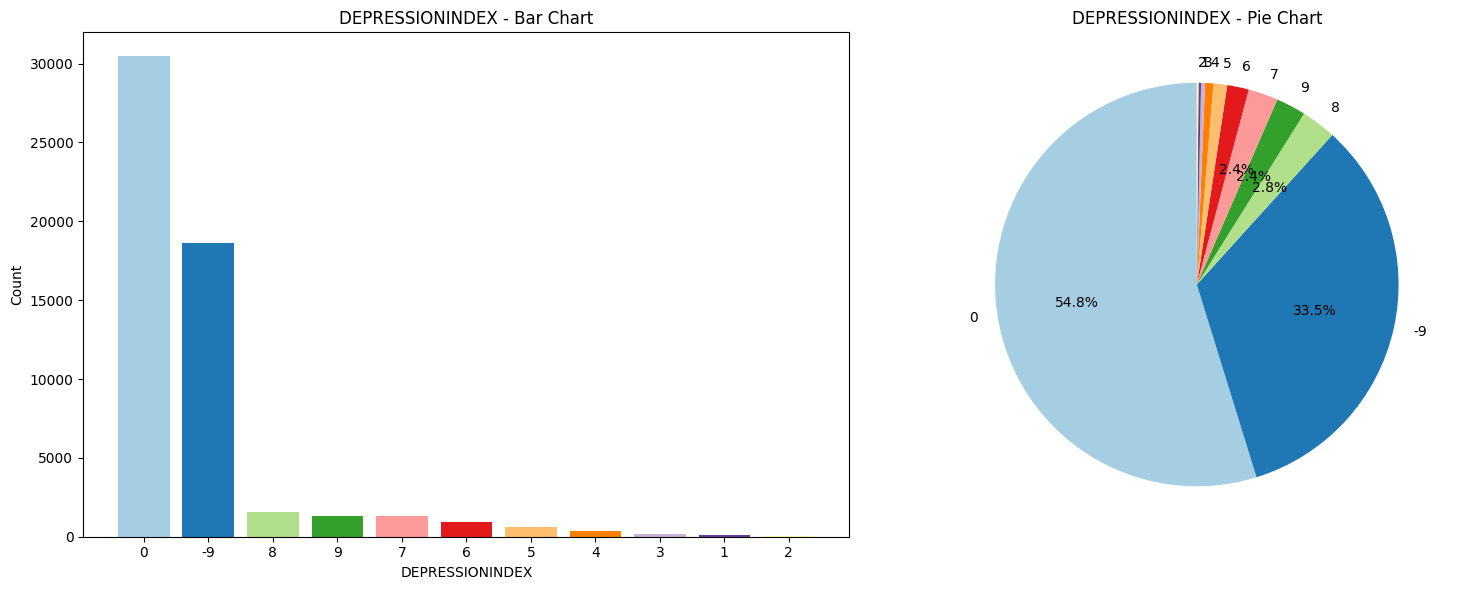

In [5]:
plot_percentage_barplot(df_filtered, 'DEPRESSIONINDEX')

In [6]:
df_filtered['DEPRESSIONINDEX'] = df_filtered['DEPRESSIONINDEX'].replace(-9, np.nan)
df_filtered = df_filtered.dropna(subset=['DEPRESSIONINDEX'])

Postanowiłem usunąć wszystkie rzędy z DEPRESSIONINDEX = -9

# Podział na depresje somatyczną i niesomatyczną

In [7]:
#YO_MDEA4 - 1-tak, 2-nie - Sen
#YO_MDEA3 - 1-tak, 2-nie - Apetyt
#YO_MDEA6 - 1-tak, 2-nie - Zmęczenie

df_filtered.loc[(df_filtered['DEPRESSIONINDEX'].between(1, 9)) & 
       (df_filtered['YO_MDEA4'] == 1) & 
       (df_filtered['YO_MDEA3'] == 1) & 
       (df_filtered['YO_MDEA6'] == 1), 'Somatic'] = 2

df_filtered.loc[(df_filtered['DEPRESSIONINDEX'] == 0), 'Somatic'] = 0

df_filtered.loc[(df_filtered['DEPRESSIONINDEX'].between(1, 9)) & 
       ((df_filtered['YO_MDEA4'] != 1) |
       (df_filtered['YO_MDEA3'] != 1) | 
       (df_filtered['YO_MDEA6'] != 1)), 'Somatic'] = 1

df_filtered['Somatic'].replace(np.nan, -1, inplace=True)

# Somatic - 2 - depresja somatyczn, 1 - brak depresji somatycznej, 0 - brak depresji

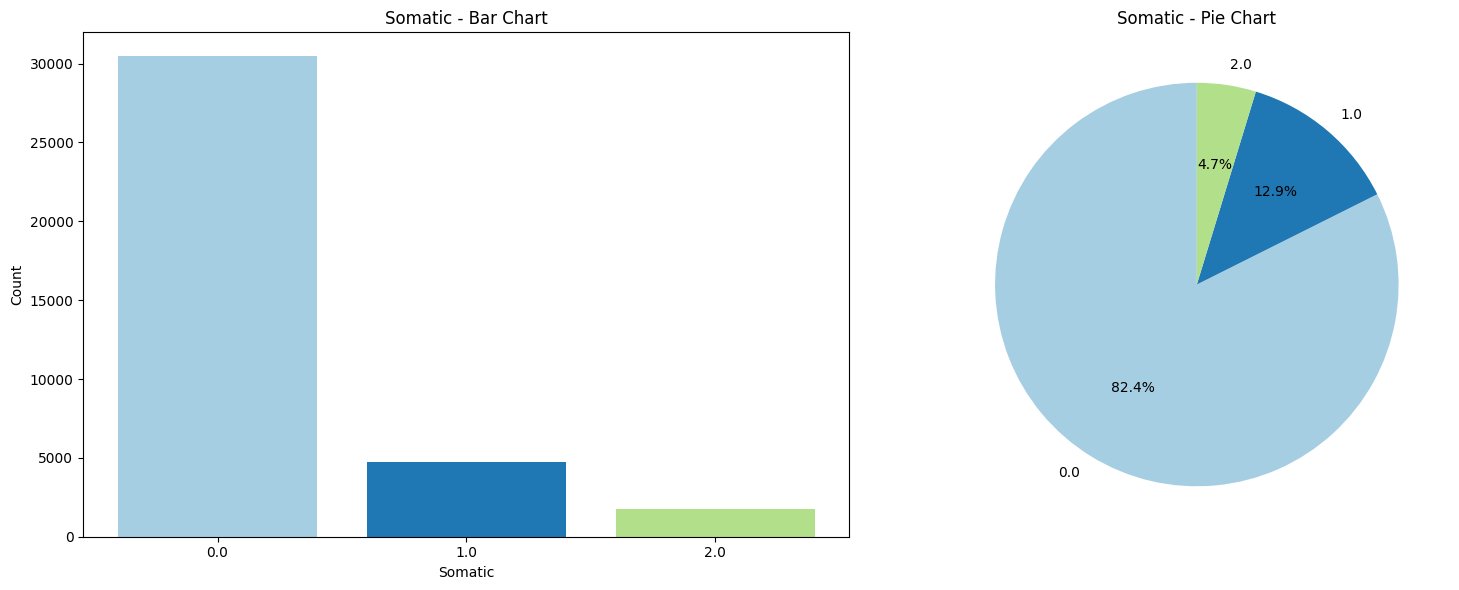

In [8]:
plot_percentage_barplot(df_filtered, 'Somatic')

2 - depresja somatyczn  
1 - brak depresji somatycznej  
0 - brak depresji

# Operacje na brakach w danych

## Sprawdzenie które kolumny występują tylko dla pozytywnych wartości w DEPRESSIONINDEX

In [9]:
pd.set_option('display.max_rows', None)

check_nan_data = df_filtered.copy()

check_nan_data[check_nan_data == -1] = np.nan
check_nan_data[check_nan_data == -9] = np.nan

check_nan_data['YO_MDEA4'].replace([99, 98, 94, 97], np.nan, inplace=True)
check_nan_data['MOVESPY2'].replace([998, 997, 994], np.nan, inplace=True)
check_nan_data['SCHDSKIP'].replace([89, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['SCHDSICK'].replace([89, 90, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['ALCFMFPB'].replace([94, 97, 98], np.nan, inplace=True)
check_nan_data['ADWRSTHK'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['NOMARR2'].replace([94, 97, 99], np.nan, inplace=True)
check_nan_data['ADWRELES'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['YO_MDEA3'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['YO_MDEA6'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['ADWRSMOR'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['ADWRSLEP'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['ADWRDLOT'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['YOWRSPLN'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['YOWRSATP'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTNRVOS'].replace([85, 89, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTCHEER'].replace([85, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTDEPRS'].replace([89, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTSITST'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTTIRE'].replace([89, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTNCALM'].replace([94, 97, 98, 99], np.nan, inplace=True)

missing_percentage = check_nan_data.isna().mean() * 100


In [10]:
missing_percentage_without_depression = check_nan_data[check_nan_data['DEPRESSIONINDEX'] == 0].isna().mean() * 100
missing_percentage_with_depression = check_nan_data[check_nan_data['DEPRESSIONINDEX'] != 0].isna().mean() * 100

In [11]:
comparison_df = pd.DataFrame({
    'Column': missing_percentage_without_depression.index,
    'Without Depression': missing_percentage_without_depression.values,
    'With Depression': missing_percentage_with_depression.values,
    'Overall': missing_percentage.values,
    'Difference': missing_percentage_with_depression.values - missing_percentage_without_depression.values
})
comparison_df = comparison_df.sort_values(by='Overall', ascending=False)
comparison_df[comparison_df['Without Depression'] == 100]

,Column,Without Depression,With Depression,Overall,Difference
42,DSTNCALM,100.0,100.000000,100.000000,0.000000
45,DSTDEPRS,100.0,100.000000,100.000000,0.000000
43,DSTTIRE,100.0,100.000000,100.000000,0.000000
44,DSTSITST,100.0,100.000000,100.000000,0.000000
54,ADWRSMOR,100.0,90.204207,98.274370,-9.795793
48,YOWRSATP,100.0,77.982497,96.121389,-22.017503
49,YOWRSPLN,100.0,77.890373,96.105161,-22.109627
55,YO_MDEA3,100.0,55.688623,92.194093,-44.311377
52,YO_MDEA4,100.0,55.489022,92.158931,-44.510978
8,YO_MDEA6,100.0,55.396899,92.142703,-44.603101


In [12]:
comparison_df = comparison_df[comparison_df['Difference'].abs() > 10]
Depression_column=comparison_df['Column'].values.tolist()
Depression_column

['YOWRSATP',
 'YOWRSPLN',
 'YO_MDEA3',
 'YO_MDEA4',
 'YO_MDEA6',
 'ADWRELES',
 'ADWRSLEP',
 'ADWRSTHK',
 'ADWRDLOT']

Jak widać jest kilka kolumn dla których dane zbierane były tylko gdy osoba miała depresje 

## Usunięcie kolumn gdzie występuje ponad 60% danych brakujących

In [13]:
columns_to_drop = missing_percentage[(missing_percentage > 60)].index

for column in Depression_column:
    if column in columns_to_drop:
        columns_to_drop = columns_to_drop.drop(column)

check_nan_data.drop(columns=columns_to_drop, inplace=True)

df_filtered = check_nan_data
df_filtered['DEPRESSIONINDEX'] = df_filtered['DEPRESSIONINDEX'].astype(int)

df_filtered_without_DEPRESSIONINDEX = check_nan_data.drop(columns=['DEPRESSIONINDEX'])

## Uzupełnienie brakujących danych

In [14]:
df_filtered.drop(columns=['SCHDSICK', 'SCHDSKIP', 'DSTCHEER', 'DSTNRVOS'], inplace=True)
column_with_missing_values = df_filtered.columns[df_filtered.isna().any()].tolist()

column_with_missing_values

['ANYTXRXMDE',
 'ANYINDEX',
 'YO_MDEA6',
 'COKECRACK',
 'MJGT12MO',
 'COCGT12MO',
 'ANYGT12MO',
 'ALCFMFPB',
 'WORKFORCE',
 'MOVESPY2',
 'CACHAR',
 'CATYPE',
 'CRIMEHIST',
 'ANYSDRUG',
 'ANYATTACK',
 'ANYTHEFT',
 'NUMARREST',
 'HEALTH2',
 'YOWRSATP',
 'YOWRSPLN',
 'ADWRDLOT',
 'ADWRSTHK',
 'YO_MDEA4',
 'ADWRSLEP',
 'YO_MDEA3',
 'ADWRELES',
 'RKIDSHH']

In [15]:
columns_without_missing_values = df_filtered.columns[~df_filtered.isna().any()]
df_without_missing_values = df_filtered[columns_without_missing_values]

X = df_without_missing_values.drop(columns=['DEPRESSIONINDEX']) 
y = df_without_missing_values['DEPRESSIONINDEX']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')

method = 0
low_mse = 1000

def impute_missing_values(df, column):
    low_mse = 1000
    for method in range(3):
        # print(f'Column: {column} - Method: {method}')
        if method == 0:
            imputer = SimpleImputer(strategy='median')
        if method == 1:
            imputer = SimpleImputer(strategy='mean')
        if method == 2:
            imputer = KNNImputer(n_neighbors=3)

        df_sampled = df_without_missing_values.sample(frac=0.2, random_state=42)

        df_imputed = pd.DataFrame(imputer.fit_transform(df_sampled), columns=df_sampled.columns)

        X = df_imputed.drop(columns=['DEPRESSIONINDEX']) 
        y = df_imputed['DEPRESSIONINDEX']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        if mse < low_mse:
            low_mse = mse
            best_method = imputer

        method += 1

    return low_mse, best_method


for column in column_with_missing_values:
    df_without_missing_values = pd.concat([df_without_missing_values, df_filtered[column]], axis=1)
    mse, imputer = impute_missing_values(df_without_missing_values, column)
    print(f'Mean Squared Error: {mse}, Method: {imputer}, Column: {column}')
    df_without_missing_values[column] = imputer.fit_transform(df_without_missing_values[[column]])



Mean Squared Error: 0.9486102800793997
Mean Squared Error: 0.8321745694830879, Method: SimpleImputer(strategy='median'), Column: ANYTXRXMDE
Mean Squared Error: 0.8278366752457478, Method: SimpleImputer(strategy='median'), Column: ANYINDEX
Mean Squared Error: 0.769705009536673, Method: KNNImputer(n_neighbors=3), Column: YO_MDEA6
Mean Squared Error: 0.8050368179190681, Method: KNNImputer(n_neighbors=3), Column: COKECRACK
Mean Squared Error: 0.8077855634990609, Method: SimpleImputer(), Column: MJGT12MO
Mean Squared Error: 0.8069356014990504, Method: SimpleImputer(), Column: COCGT12MO
Mean Squared Error: 0.8069581660993347, Method: SimpleImputer(strategy='median'), Column: ANYGT12MO
Mean Squared Error: 0.8065621094348847, Method: SimpleImputer(), Column: ALCFMFPB
Mean Squared Error: 0.8065054295704441, Method: SimpleImputer(strategy='median'), Column: WORKFORCE
Mean Squared Error: 0.8065479468158726, Method: KNNImputer(n_neighbors=3), Column: MOVESPY2
Mean Squared Error: 0.8060855648532406

Kod świetnie spełnia swoje zadanie podchodząc do każdej z kolumn w sposób indywidualny i wybierając dla niej najlepszy sposób uzupelniania danych

In [16]:
column_with_missing_values = df_without_missing_values.columns[df_without_missing_values.isna().any()].tolist()
nan_counts = df_without_missing_values[column_with_missing_values].isna().sum()
nan_counts

Series([], dtype: float64)

In [ ]:
num_columns = df_without_missing_values.shape[1]
print(num_columns)

num_columns = df_filtered.shape[1]
print(num_columns)

df_filtered = df_without_missing_values.copy()

52
52


# Predictive Power Score dla zmiennej DEPRESSIONINDEX

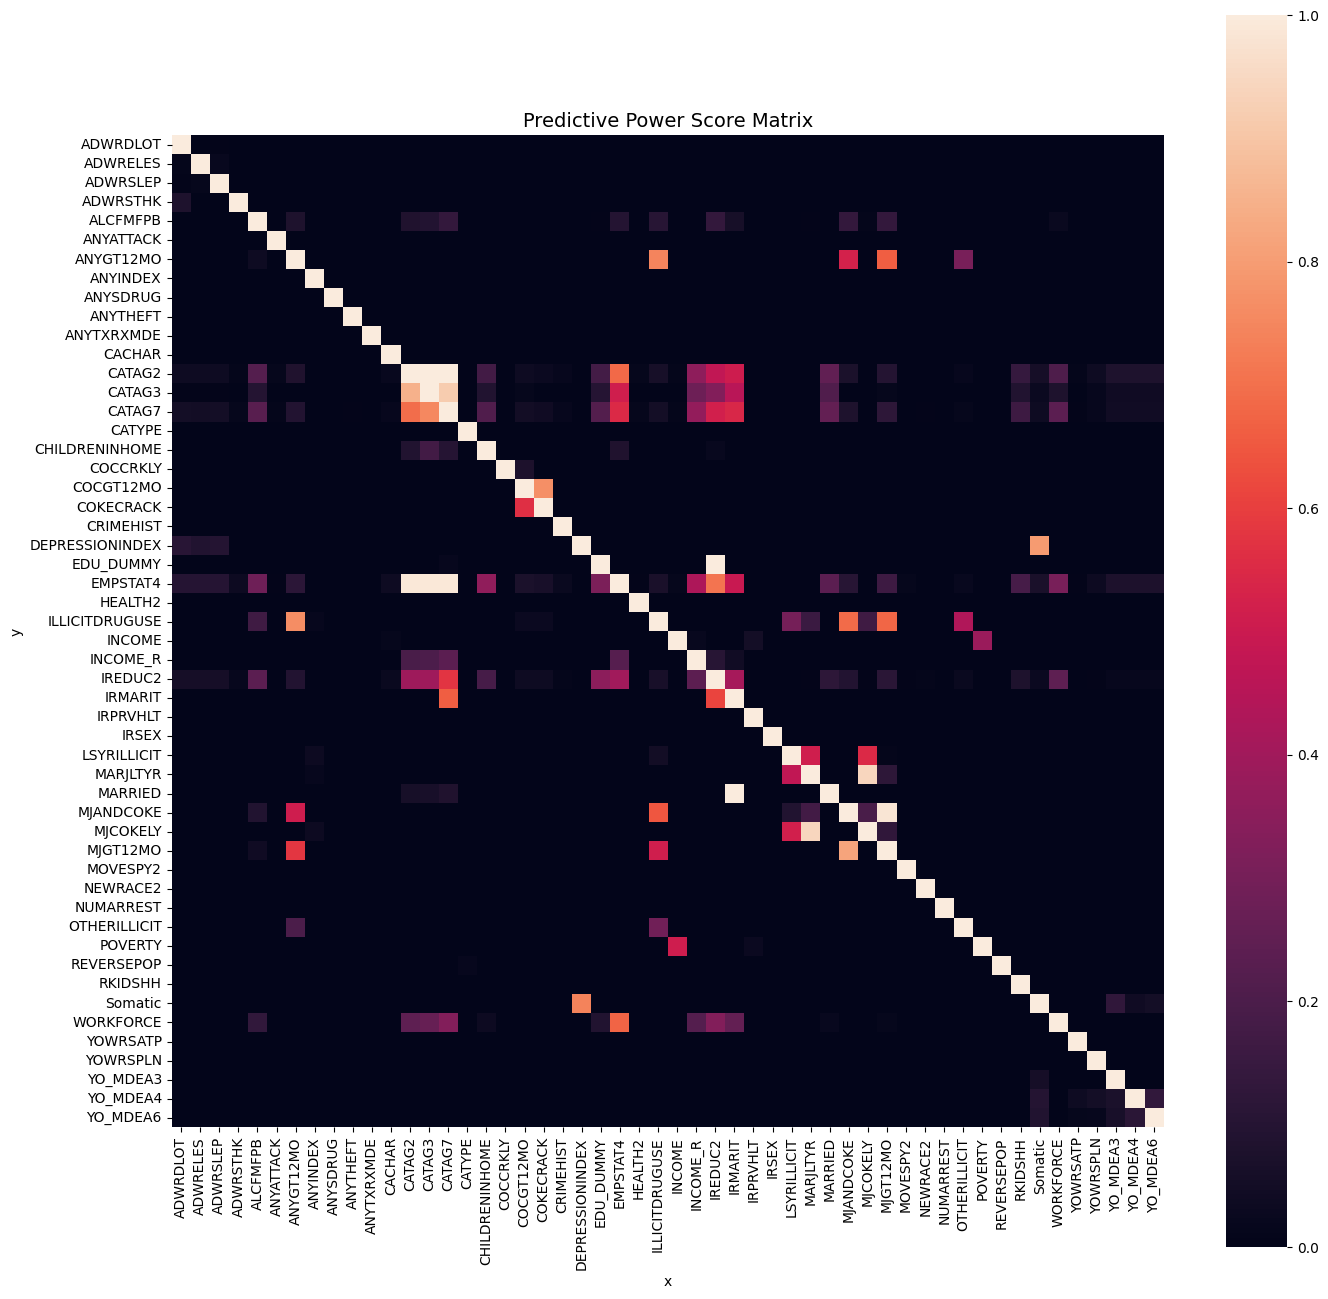

In [18]:
pps_matrix = pps.matrix(df_filtered)
pps_matrix = pps_matrix[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
plt.figure(figsize=(16, 16))
sns.heatmap(pps_matrix, vmin=0, vmax=1,square=True)
plt.title('Predictive Power Score Matrix', fontsize=14)
plt.show()

In [19]:
depression_pps_colums = pps_matrix[pps_matrix.columns == 'DEPRESSIONINDEX']
depression_pps_colums = depression_pps_colums.loc[:, depression_pps_colums.ne(0).any(axis=0)]
depression_pps_colums


x,ADWRDLOT,ADWRELES,ADWRSLEP,DEPRESSIONINDEX,Somatic
y,,,,,
DEPRESSIONINDEX,0.105941,0.089003,0.095438,1.0,0.796583


In [20]:
features_to_drop = ['ANYTXRXMDE']
df_filtered_without_DEPRESSIONINDEX = df_filtered_without_DEPRESSIONINDEX.drop(columns=features_to_drop)
df_filtered = df_filtered.drop(columns=features_to_drop)

Nawet że PPS nie wykazał związku DEPRESSIONINDEX z ANYTXRXMDE postanawiam usunąć tą kolumne ze względu na możliwe przecieki danych

# Korelacja Cech

## Wyznaczenie macierzy korelacji

In [21]:
df_filtered_without_DEPRESSIONINDEX.shape

(36972, 54)

In [22]:
correlation_matrix = df_filtered_without_DEPRESSIONINDEX.corr(method='pearson')
# plt.figure(figsize=(15, 15))
# sns.heatmap(correlation_matrix, fmt=".2f")
# plt.title("Pearson Correlation Matrix",fontsize=14)
# plt.show()

correlation_matrix2 = df_filtered_without_DEPRESSIONINDEX.corr(method='spearman')
# plt.figure(figsize=(15, 15))
# sns.heatmap(correlation_matrix2, fmt=".2f")
# plt.title("Spearman Correlation Matrix",fontsize=14)
# plt.show()


In [23]:
corr_threshold = 0.8
corr_pairs = (correlation_matrix.abs() > corr_threshold) & (correlation_matrix < 1)
corr_pairs = corr_pairs.unstack().reset_index()
corr_pairs = corr_pairs[corr_pairs[0]]
corr_pairs = corr_pairs[corr_pairs.level_0 < corr_pairs.level_1]
corr_pairs = corr_pairs.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation"})

corr_pairs2 = (correlation_matrix2.abs() > corr_threshold) & (correlation_matrix2 < 1)
corr_pairs2 = corr_pairs2.unstack().reset_index()
corr_pairs2 = corr_pairs2[corr_pairs2[0]]
corr_pairs2 = corr_pairs2[corr_pairs2.level_0 < corr_pairs2.level_1]
corr_pairs2 = corr_pairs2.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation"})

corr_pairs = pd.concat([corr_pairs, corr_pairs2])
corr_pairs = corr_pairs.drop_duplicates()


## Grupowanie zmiennych zależnych i redukcja cech

In [ ]:

graph = nx.Graph()

features = pd.concat([corr_pairs['Feature 1'], corr_pairs['Feature 2']]).unique()
graph.add_nodes_from(features)

edges = corr_pairs[['Feature 1', 'Feature 2']].values
graph.add_edges_from(edges)

connected_components = list(nx.connected_components(graph))

groups_df = pd.DataFrame({
    "Group": [f"Group {i+1}" for i in range(len(connected_components))],
    "Features": [", ".join(sorted(component)) for component in connected_components]
})

pd.set_option('display.max_colwidth', None)
groups_df


,Group,Features
0,Group 1,"CATAG2, CATAG3, CATAG7, EMPSTAT4, IREDUC2, IRMARIT"
1,Group 2,"ANYGT12MO, ILLICITDRUGUSE, MJANDCOKE, MJGT12MO"
2,Group 3,"LSYRILLICIT, MARJLTYR, MJCOKELY"


In [25]:
depression_corr1 = df_filtered.corr(method='pearson')['DEPRESSIONINDEX'].abs()
depression_corr2 = df_filtered.corr(method='spearman')['DEPRESSIONINDEX'].abs()

combined_corr = pd.concat([depression_corr1, depression_corr2], axis=1).max(axis=1)
combined_corr.sort_values(ascending=False, inplace=True)
combined_corr

DEPRESSIONINDEX    1.000000
Somatic            0.993431
YO_MDEA4           0.499338
ADWRSTHK           0.469481
YO_MDEA6           0.464604
ADWRSLEP           0.459295
YO_MDEA3           0.317236
YOWRSATP           0.306543
OTHERILLICIT       0.183496
ILLICITDRUGUSE     0.182700
ADWRELES           0.172675
ANYGT12MO          0.164626
MJANDCOKE          0.149675
IRSEX              0.148019
MJGT12MO           0.142717
LSYRILLICIT        0.136487
ANYINDEX           0.130577
HEALTH2            0.112893
MJCOKELY           0.102968
COCGT12MO          0.100394
MARJLTYR           0.099455
COKECRACK          0.098972
ANYATTACK          0.096989
ADWRDLOT           0.094046
ALCFMFPB           0.081427
IRMARIT            0.079328
IREDUC2            0.072569
COCCRKLY           0.061653
MOVESPY2           0.061419
ANYTHEFT           0.059162
CRIMEHIST          0.057658
CATAG7             0.050720
ANYSDRUG           0.050480
WORKFORCE          0.036760
EMPSTAT4           0.035647
NUMARREST          0

In [26]:
best_features = []
for group in connected_components:
    group_corr = combined_corr[list(group)]  
    best_feature = group_corr.idxmax()  
    best_features.append(best_feature)

best_features_df = pd.DataFrame({
    "Group": [f"Group {i+1}" for i in range(len(best_features))],
    "Best Feature": best_features
})

best_features_df

,Group,Best Feature
0,Group 1,IRMARIT
1,Group 2,ILLICITDRUGUSE
2,Group 3,LSYRILLICIT


In [ ]:
all_unique_features = list(set([feature for group in connected_components for feature in group]))
features_to_drop = list(set(all_unique_features) - set(best_features))
features_to_drop

['MJGT12MO',
 'CATAG3',
 'EMPSTAT4',
 'ANYGT12MO',
 'MJANDCOKE',
 'MARJLTYR',
 'CATAG7',
 'IREDUC2',
 'CATAG2',
 'MJCOKELY']

# Podział na zbiór do predykcji depresji i zbiór do predykcji skali depresji

In [28]:
new_correlation_matrix = df_filtered.drop(columns=features_to_drop)

interesting_columns = []

In [29]:
Depression_column

['YOWRSATP',
 'YOWRSPLN',
 'YO_MDEA3',
 'YO_MDEA4',
 'YO_MDEA6',
 'ADWRELES',
 'ADWRSLEP',
 'ADWRSTHK',
 'ADWRDLOT']

In [30]:
df_filtered_for_depressio_scale = new_correlation_matrix.copy()
for column in Depression_column:
    if column in new_correlation_matrix.columns:
        new_correlation_matrix.drop(columns=column, inplace=True)

new_correlation_matrix.drop(columns=['Somatic'], inplace=True)

In [31]:
print(new_correlation_matrix.shape)
print(df_filtered_for_depressio_scale.shape)

(36972, 31)
(36972, 41)


# Wybór kluczowych cech dla modelu predykcji depresji

## Korelacja "spearman" dla cech najbardziej skorelowanych z DEPRESSIONINDEX

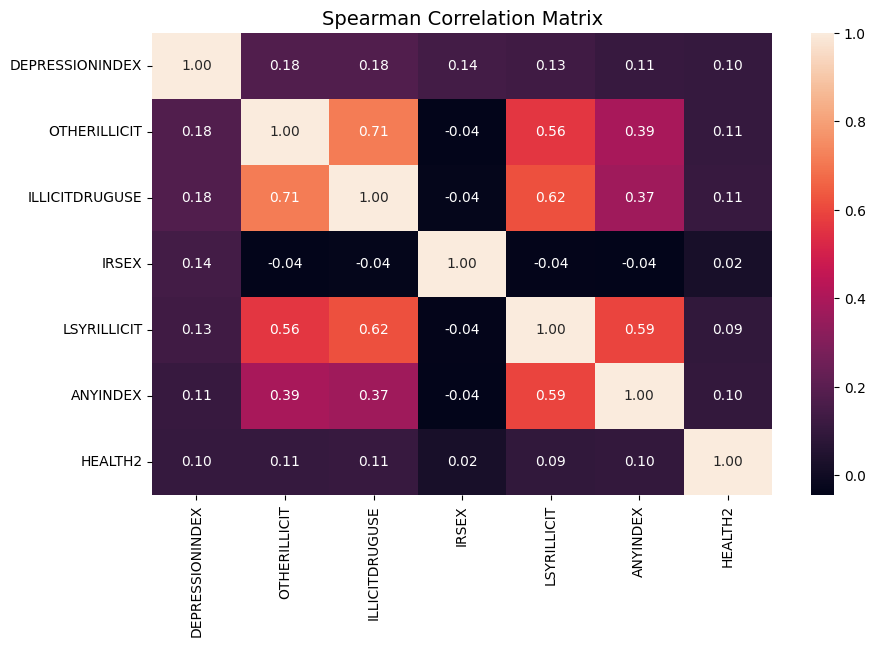

In [32]:
list_to_check = new_correlation_matrix.corr(method='spearman')['DEPRESSIONINDEX'].abs().sort_values(ascending=False)
list_to_check_new = list_to_check[:7].index.tolist()
interesting_columns.append(list_to_check_new)
corr_data = new_correlation_matrix[list_to_check_new]
corr_data.corr(method='spearman')
plt.figure(figsize=(10, 6))
sns.heatmap(corr_data.corr(method='spearman'), fmt=".2f", annot=True)
plt.title("Spearman Correlation Matrix",fontsize=14)
plt.show()

## Test Manna-Whitneya dla danych binarnych i DEPRESSIONINDEX

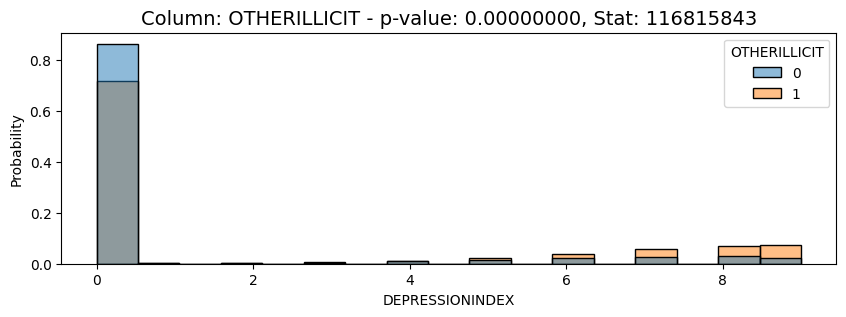

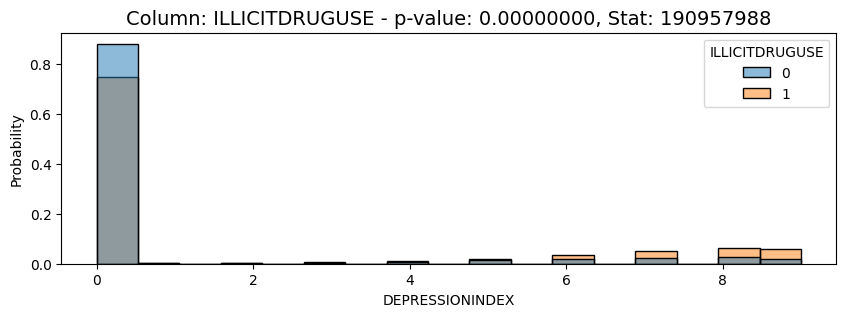

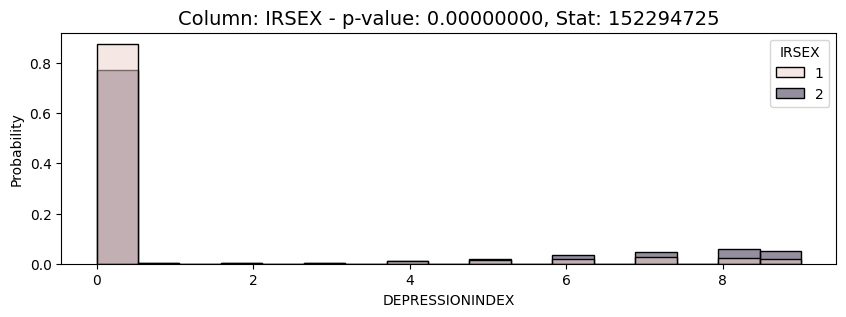

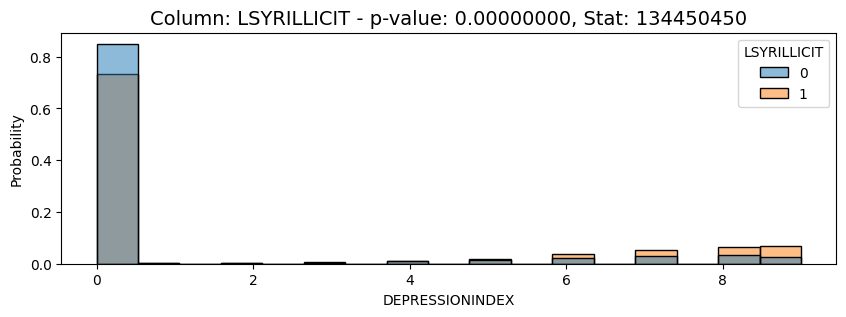

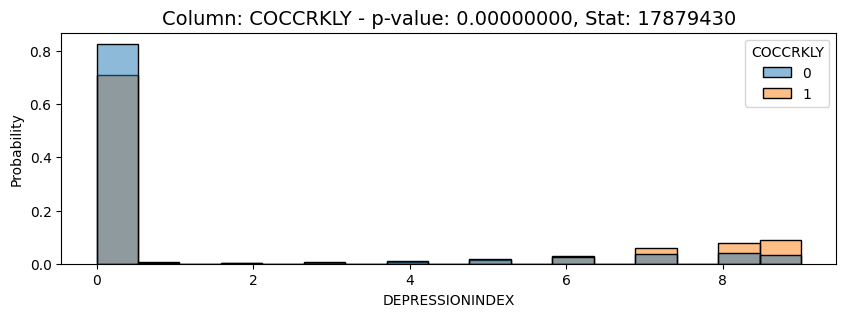

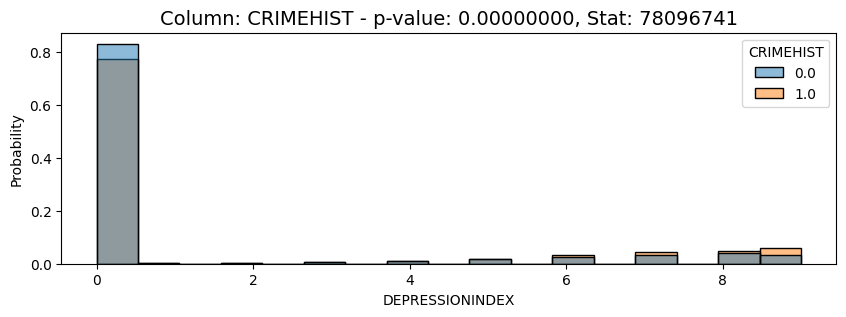

In [33]:
df_filtered = new_correlation_matrix

p_values = []

for column in df_filtered.columns:
    if column != 'DEPRESSIONINDEX':
        unique_values = df_filtered[column].unique()
        if len(unique_values) == 2:  
            group1 = df_filtered[df_filtered[column] == unique_values[0]]['DEPRESSIONINDEX']
            group2 = df_filtered[df_filtered[column] == unique_values[1]]['DEPRESSIONINDEX']
            stat, p_value = mannwhitneyu(group1, group2)
            p_values.append((column, p_value))


p_values_sorted = sorted(p_values, key=lambda x: x[1])
top_5_features = p_values_sorted[:6]
interesting_columns.append([column for column, p_value in top_5_features])
for column, p_value in top_5_features:
        if column != 'DEPRESSIONINDEX':
            unique_values = df_filtered[column].unique()
            group1 = df_filtered[df_filtered[column] == unique_values[0]]['DEPRESSIONINDEX']
            group2 = df_filtered[df_filtered[column] == unique_values[1]]['DEPRESSIONINDEX']
            stat, p_value = mannwhitneyu(group1, group2)
            title = f'Column: {column} - p-value: {p_value:.8f}, Stat: {stat:.0f}'   

            plt.figure(figsize=(10, 3))
            sns.histplot(df_filtered, x='DEPRESSIONINDEX', hue=column, stat='probability', common_norm=False)
            plt.title(title, fontsize=14)
            plt.show()
            


Jak widać na wykresach każda z 6 zmiennych jest istotna statystycznie i wystepują istotne różnice miedzy grupami

## Test Kruskala-Wallisa dla danych kategorycznych i DEPRESSIONINDEX

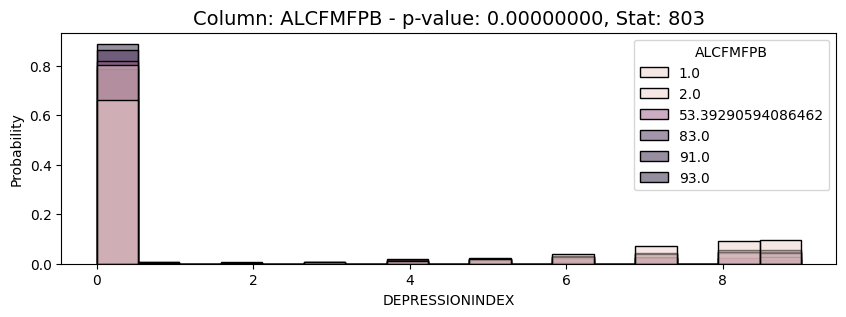

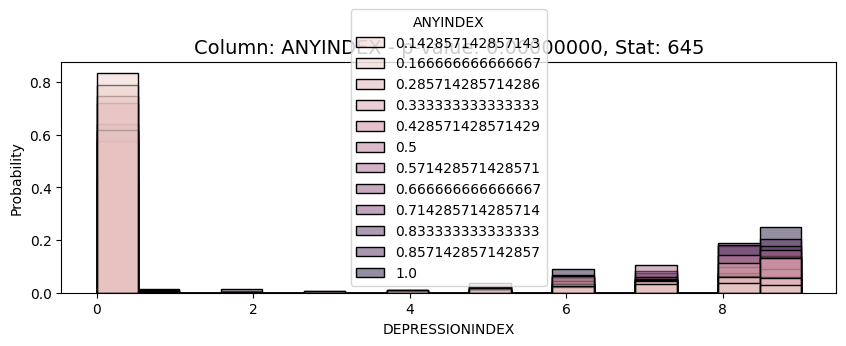

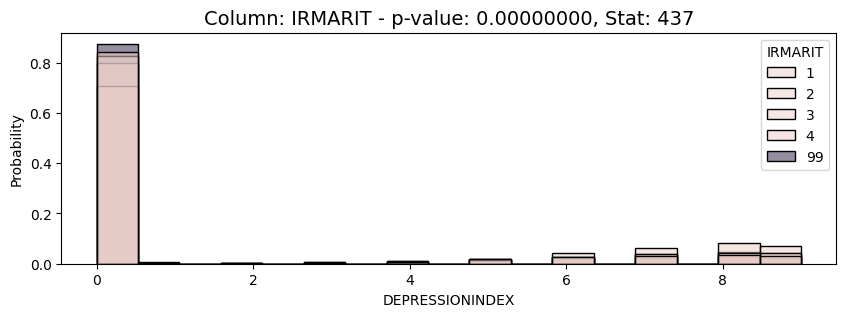

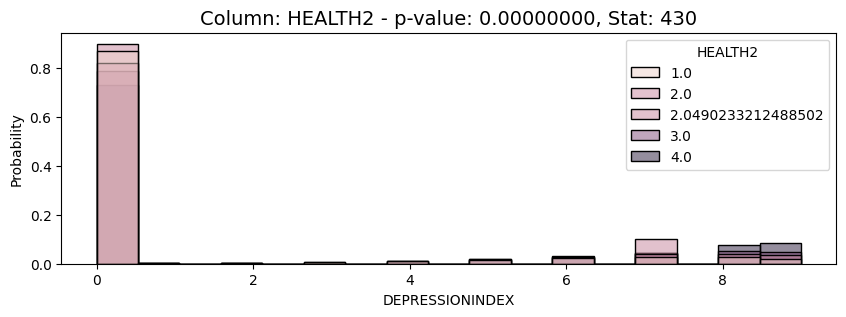

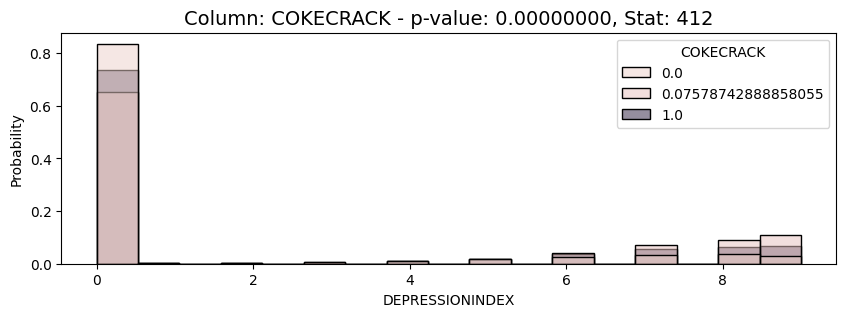

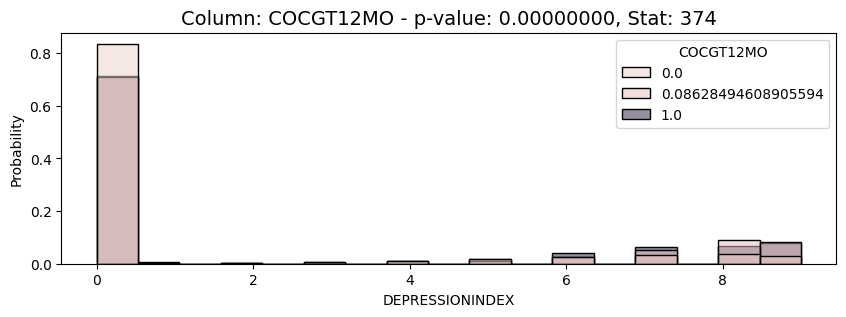

In [34]:
df_filtered = new_correlation_matrix
y = df_filtered['DEPRESSIONINDEX']
p_values = []

for column in df_filtered.columns:
    if column != 'DEPRESSIONINDEX':
        unique_values = df_filtered[column].unique()
        if len(unique_values) > 2:
            groups = [df_filtered[df_filtered[column] == value]['DEPRESSIONINDEX'] for value in unique_values]
            stat, p_value = kruskal(*groups)
            p_values.append((column, p_value))

p_values_sorted = sorted(p_values, key=lambda x: x[1])
top_5_features = p_values_sorted[:6]
interesting_columns.append([column for column, p_value in top_5_features])
for column, p_value in top_5_features:
        if column != 'DEPRESSIONINDEX':
            unique_values = df_filtered[column].unique()
            groups = [df_filtered[df_filtered[column] == value]['DEPRESSIONINDEX'] for value in unique_values]
            stat, p_value = kruskal(*groups)
            title = f'Column: {column} - p-value: {p_value:.8f}, Stat: {stat:.0f}'   

            plt.figure(figsize=(10, 3))
            sns.histplot(df_filtered, x='DEPRESSIONINDEX', hue=column, stat='probability', common_norm=False)
            plt.title(title, fontsize=14)
            plt.show()

Jak widać na wykresach każda z 6 zmiennych jest istotna statystycznie i wystepują istotne różnice miedzy grupami

## Wyniki

In [35]:
flat_list = [item for sublist in interesting_columns for item in sublist]
flat_list = [item for item in flat_list if item != 'DEPRESSIONINDEX']
series = pd.Series(flat_list)
counts = series.value_counts()

index = counts[:6].index.tolist()
index

['OTHERILLICIT',
 'ILLICITDRUGUSE',
 'IRSEX',
 'LSYRILLICIT',
 'ANYINDEX',
 'HEALTH2']

Lista 6 zmiennych wybranych do stworzenia modelu predykcji

# Wybór kluczowych cech dla modelu predykcji skali depresji

In [36]:
new_df_filtered_for_depressio_scale = df_filtered_for_depressio_scale[df_filtered_for_depressio_scale['DEPRESSIONINDEX'] != 0]

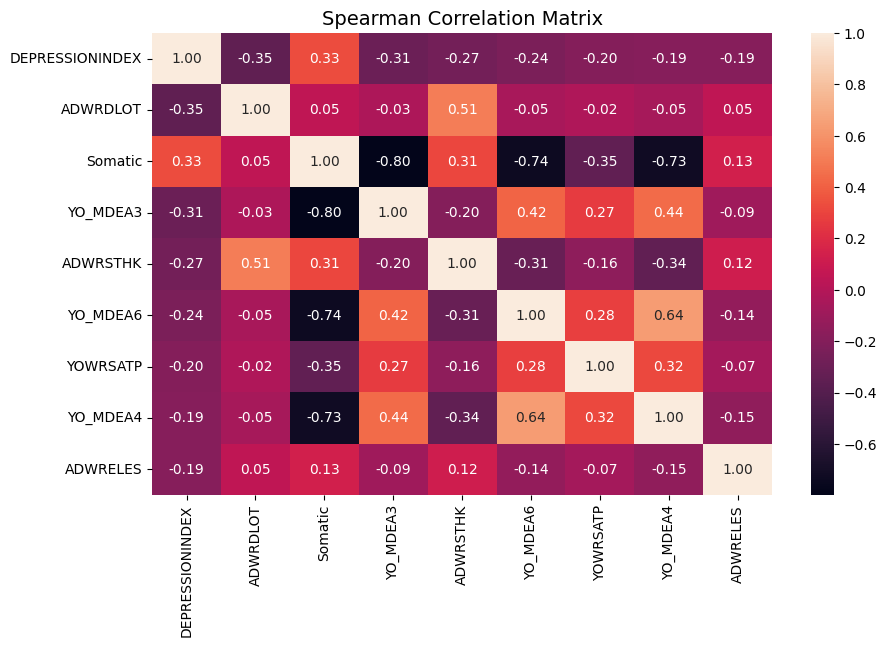

In [37]:
list_to_check = new_df_filtered_for_depressio_scale.corr(method='spearman')['DEPRESSIONINDEX'].abs().sort_values(ascending=False)
list_to_check_new = list_to_check[:9].index.tolist()
interesting_columns.append(list_to_check_new)
corr_data = new_df_filtered_for_depressio_scale[list_to_check_new]
corr_data.corr(method='spearman')
plt.figure(figsize=(10, 6))
sns.heatmap(corr_data.corr(method='spearman'), fmt=".2f", annot=True)
plt.title("Spearman Correlation Matrix",fontsize=14)
plt.show()

In [38]:
df_filtered_for_depressio_scale = df_filtered_for_depressio_scale[list_to_check_new]

# Modelowanie danych

## Podział zbioru na test, train, val

In [39]:
index.append('DEPRESSIONINDEX')
Boost_data = df_filtered[index]

majority_class = Boost_data[Boost_data['DEPRESSIONINDEX'] == 0]
minority_class = Boost_data[Boost_data['DEPRESSIONINDEX'] != 0]

minority_oversampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

Boost_data_2 = pd.concat([majority_class, minority_oversampled])

X = Boost_data_2.drop(columns='DEPRESSIONINDEX')
y = Boost_data_2['DEPRESSIONINDEX']

y_binary = (y != 0).astype(int)


X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)
X_test_2, X_val_2, y_test_2, y_val_2 = train_test_split(X_test_2, y_test_2, test_size=0.5, random_state=42)


In [40]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(48734, 6) (6092, 6) (6092, 6)
(48734,) (6092,) (6092,)


## Sprawdzenie rozkładu danych

### Test Kolmogorowa-Smirnowa by sprawdzić czy rozkład zmiennej Y jest taki sam

In [ ]:
stat, p_value = ks_2samp(y_train, y_val)
print(f'Test KS dla Train vs Validation: p-value={p_value}')

stat, p_value = ks_2samp(y_train, y_test)
print(f'Test KS dla Train vs Test: p-value={p_value}')

stat, p_value = ks_2samp(y_val, y_test)
print(f'Test KS dla Validation vs Test: p-value={p_value}')

Test KS dla Train vs Validation: p-value=0.9996798592546141
Test KS dla Train vs Test: p-value=0.9999999922751829
Test KS dla Validation vs Test: p-value=0.9999999999999996


### Test PCA by sprawdzić czy rozkładny zmiennej X są takie same

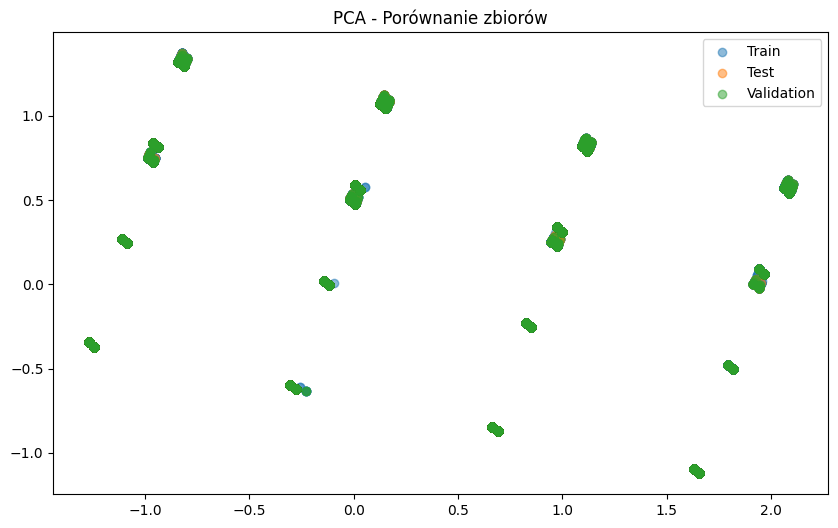

In [42]:
pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], label='Train', alpha=0.5)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], label='Test', alpha=0.5)
plt.scatter(X_val_pca[:, 0], X_val_pca[:, 1], label='Validation', alpha=0.5)

plt.legend()
plt.title('PCA - Porównanie zbiorów')
plt.show()

# Model do kalsyfikacji jest/nie ma depresji

## Model CatBoost

In [43]:
model = CatBoostClassifier(
    iterations=300,
    depth=12,
    learning_rate=0.1,
    verbose=50,
)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))

0:	learn: 0.6826547	total: 73.3ms	remaining: 21.9s
50:	learn: 0.6349366	total: 1.18s	remaining: 5.76s
100:	learn: 0.6344219	total: 1.97s	remaining: 3.89s
150:	learn: 0.6340701	total: 4.93s	remaining: 4.87s
200:	learn: 0.6340088	total: 7.79s	remaining: 3.83s
250:	learn: 0.6339954	total: 9.65s	remaining: 1.89s
299:	learn: 0.6339950	total: 10.3s	remaining: 0us
              precision    recall  f1-score   support

           0       0.62      0.65      0.64      3022
           1       0.64      0.60      0.62      3070

    accuracy                           0.63      6092
   macro avg       0.63      0.63      0.63      6092
weighted avg       0.63      0.63      0.63      6092



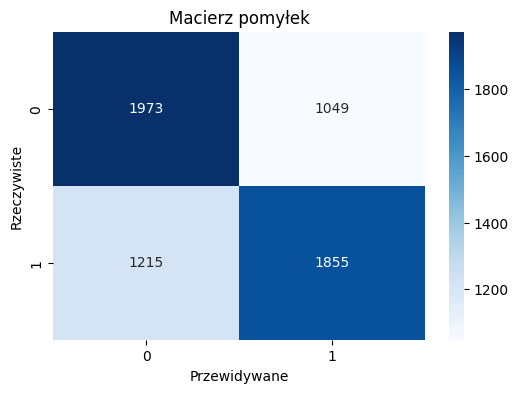

In [44]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

## Model OLS

In [45]:
X_train_ols = sm.add_constant(X_train)
X_val_ols = sm.add_constant(X_val)

ols_model = sm.OLS(y_train, X_train_ols).fit()
predictions = ols_model.predict(X_val_ols)

probabilities = 1 / (1 + np.exp(-predictions))

threshold = 0.61
y_pred = (probabilities >= threshold).astype(int)


print(ols_model.summary())



                            OLS Regression Results                            
Dep. Variable:        DEPRESSIONINDEX   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     938.2
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        13:36:59   Log-Likelihood:                -32707.
No. Observations:               48734   AIC:                         6.543e+04
Df Residuals:                   48727   BIC:                         6.549e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0392      0.009     -4.

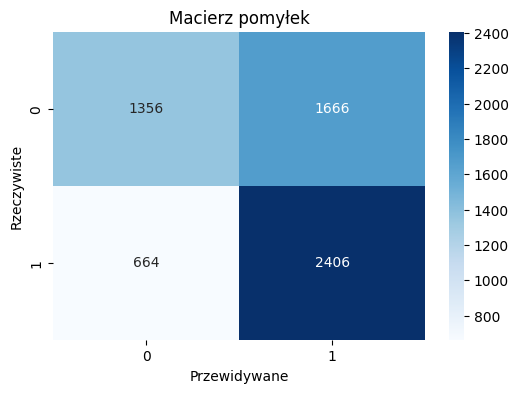

In [46]:
conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

## Model XGB

In [47]:
model = xgb.XGBClassifier(n_estimators=300, max_depth=12, learning_rate=0.1, verbosity=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

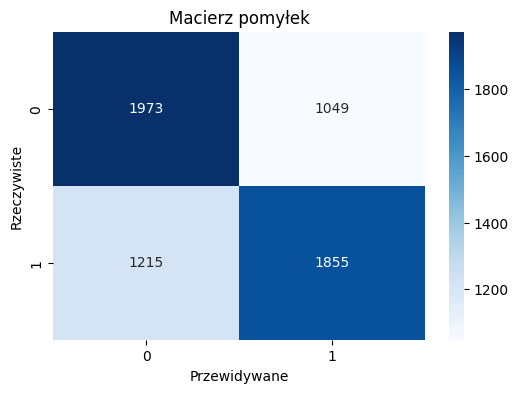

In [48]:
conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

# Model do kalsyfikacji skali depresji w całym zbiorze

## Model CatBoost

In [49]:
model = CatBoostClassifier(
    iterations=300,
    depth=12,
    learning_rate=0.1,
    verbose=50,
)

model.fit(X_train_2, y_train_2)

y_pred_2 = model.predict(X_val_2)

print(classification_report(y_val_2, y_pred_2))

0:	learn: 2.0879394	total: 26.7ms	remaining: 7.99s
50:	learn: 1.5162471	total: 1.9s	remaining: 9.27s
100:	learn: 1.5085715	total: 3.76s	remaining: 7.4s
150:	learn: 1.5047402	total: 7.59s	remaining: 7.49s
200:	learn: 1.5035259	total: 12s	remaining: 5.93s
250:	learn: 1.5029817	total: 16.6s	remaining: 3.24s
299:	learn: 1.5026684	total: 21.1s	remaining: 0us
              precision    recall  f1-score   support

           0       0.52      0.96      0.68      3022
           1       0.00      0.00      0.00        67
           2       0.00      0.00      0.00        41
           3       0.00      0.00      0.00        80
           4       0.50      0.01      0.01       170
           5       0.00      0.00      0.00       269
           6       0.38      0.01      0.03       453
           7       0.28      0.02      0.03       644
           8       0.35      0.06      0.11       737
           9       0.33      0.20      0.25       609

    accuracy                           0.51     

/home/krzysztof/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/krzysztof/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/krzysztof/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

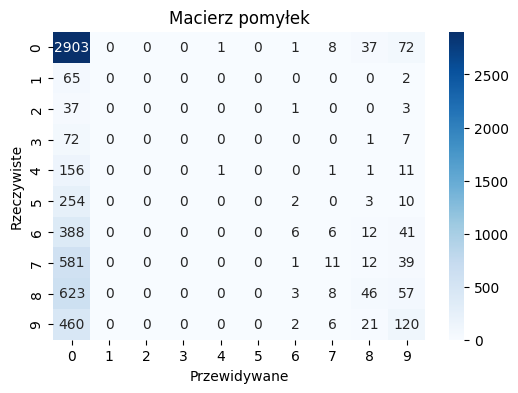

In [50]:
cm = confusion_matrix(y_val_2, y_pred_2)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

## Model OLS

In [51]:
X_train_ols = sm.add_constant(X_train_2)
X_val_ols = sm.add_constant(X_val_2)

ols_model = sm.OLS(y_train_2, X_train_ols).fit()
predictions = ols_model.predict(X_val_ols)

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:        DEPRESSIONINDEX   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     1254.
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        13:37:26   Log-Likelihood:            -1.2917e+05
No. Observations:               48734   AIC:                         2.584e+05
Df Residuals:                   48727   BIC:                         2.584e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.1892      0.066    -17.

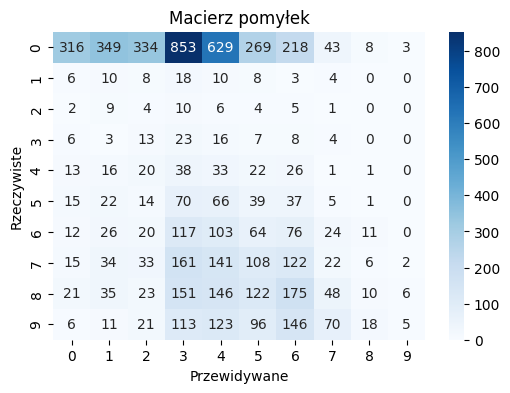

In [52]:
min_val = predictions.min()
max_val = predictions.max()

bins = np.linspace(min_val, max_val, num=10)
y_pred_classes = np.digitize(predictions, bins=bins, right=True) 

conf_matrix = confusion_matrix(y_val_2, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

## Model XGB

In [53]:
model = xgb.XGBClassifier(n_estimators=300, max_depth=12, learning_rate=0.1, verbosity=1)
model.fit(X_train_2, y_train_2)
y_pred = model.predict(X_val_2)

print(classification_report(y_val_2, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.96      0.68      3022
           1       0.00      0.00      0.00        67
           2       0.00      0.00      0.00        41
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00       170
           5       0.00      0.00      0.00       269
           6       0.38      0.01      0.02       453
           7       0.28      0.02      0.03       644
           8       0.36      0.07      0.11       737
           9       0.33      0.20      0.25       609

    accuracy                           0.51      6092
   macro avg       0.19      0.13      0.11      6092
weighted avg       0.39      0.51      0.38      6092



/home/krzysztof/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/krzysztof/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/krzysztof/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

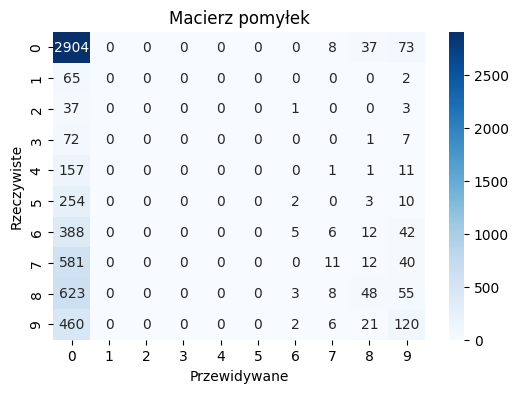

In [54]:
conf_matrix = confusion_matrix(y_val_2, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

# Model do kalsyfikacji skali depresji gdy stwierdzono depresje

## Podział zbioru na test, train, val

In [129]:

new_boost_data = df_filtered_for_depressio_scale[df_filtered_for_depressio_scale['DEPRESSIONINDEX'] != 0]

groups = new_boost_data.groupby('DEPRESSIONINDEX')

max_samples_per_class = max(groups.size())  

balanced_data = groups.apply(
    lambda x: resample(x, replace=True, n_samples=max_samples_per_class, random_state=42)
)

balanced_data = balanced_data.reset_index(drop=True)

X = balanced_data.drop(columns='DEPRESSIONINDEX')
y = balanced_data['DEPRESSIONINDEX']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=36)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=36)



In [130]:
stat, p_value = ks_2samp(y_train, y_val)
print(f'Test KS dla Train vs Validation: p-value={p_value}')

stat, p_value = ks_2samp(y_train, y_test)
print(f'Test KS dla Train vs Test: p-value={p_value}')

stat, p_value = ks_2samp(y_val, y_test)
print(f'Test KS dla Validation vs Test: p-value={p_value}')

Test KS dla Train vs Validation: p-value=0.9953118490632487
Test KS dla Train vs Test: p-value=0.861341685290947
Test KS dla Validation vs Test: p-value=0.9726984126592688


In [131]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(10482, 8) (1748, 8) (1747, 8)
(10482,) (1748,) (1747,)


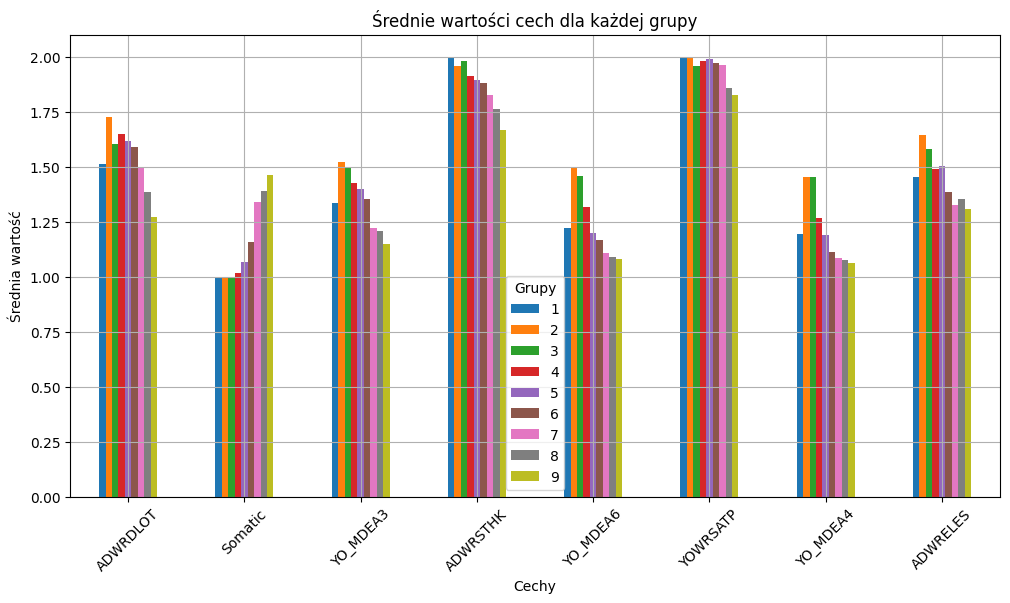

In [132]:
X_test['label'] = y_test
groups = X_test.groupby('label')
mean_features = groups.mean()

mean_features.T.plot(kind='bar', figsize=(12, 6))
plt.title('Średnie wartości cech dla każdej grupy')
plt.xlabel('Cechy')
plt.ylabel('Średnia wartość')
plt.xticks(rotation=45)
plt.legend(title='Grupy')
plt.grid(True)
plt.show()

Jak widać na wykresie istnieją znaczące różnice miedzy grupami dla każdej statystyki

## Model CatBoost

In [123]:
model_for_scale = CatBoostClassifier(
    iterations=5000,
    depth=6,
    learning_rate=0.01,
    verbose=50,
)

model_for_scale.fit(X_train, y_train)

y_pred = model_for_scale.predict(X_val)

print(classification_report(y_val, y_pred))

0:	learn: 2.1843410	total: 6.74ms	remaining: 33.7s
50:	learn: 1.8627380	total: 487ms	remaining: 47.2s
100:	learn: 1.7271957	total: 989ms	remaining: 48s
150:	learn: 1.6544621	total: 1.33s	remaining: 42.7s
200:	learn: 1.6113831	total: 1.64s	remaining: 39.2s
250:	learn: 1.5839574	total: 1.87s	remaining: 35.5s
300:	learn: 1.5661863	total: 2.15s	remaining: 33.6s
350:	learn: 1.5540337	total: 2.41s	remaining: 32s
400:	learn: 1.5458657	total: 2.65s	remaining: 30.4s
450:	learn: 1.5399304	total: 2.88s	remaining: 29s
500:	learn: 1.5354363	total: 3.11s	remaining: 28s
550:	learn: 1.5318965	total: 3.33s	remaining: 26.9s
600:	learn: 1.5288867	total: 3.57s	remaining: 26.2s
650:	learn: 1.5264869	total: 3.82s	remaining: 25.5s
700:	learn: 1.5243345	total: 4.09s	remaining: 25.1s
750:	learn: 1.5226914	total: 4.35s	remaining: 24.6s
800:	learn: 1.5213218	total: 4.6s	remaining: 24.1s
850:	learn: 1.5200130	total: 4.86s	remaining: 23.7s
900:	learn: 1.5188545	total: 5.1s	remaining: 23.2s
950:	learn: 1.5178128	to

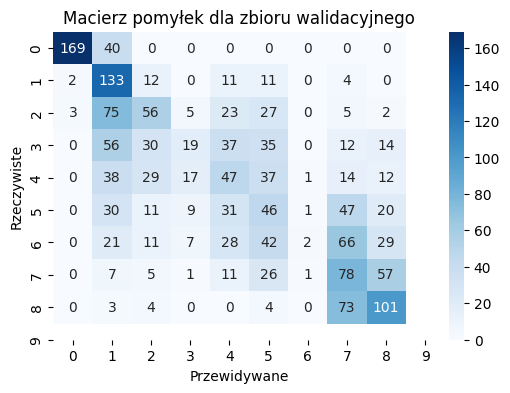

In [124]:
conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek dla zbioru walidacyjnego')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

## Model OLS

In [60]:
X_train_ols = sm.add_constant(X_train)
X_val_ols = sm.add_constant(X_val)

ols_model = sm.OLS(y_train, X_train_ols).fit()
predictions = ols_model.predict(X_val_ols)

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:        DEPRESSIONINDEX   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     1077.
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        13:38:14   Log-Likelihood:                -23285.
No. Observations:               11181   AIC:                         4.659e+04
Df Residuals:                   11172   BIC:                         4.665e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.8482      0.286     51.939      0.0

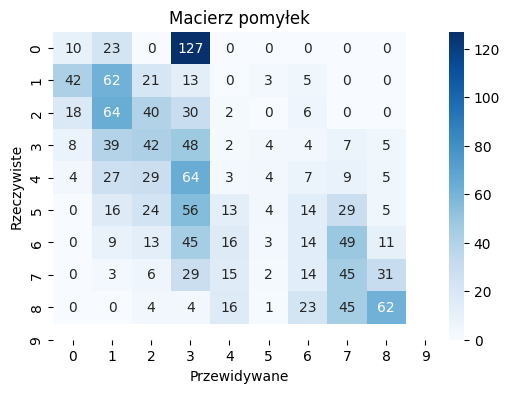

In [61]:
min_val = predictions.min()
max_val = predictions.max()

bins = np.linspace(min_val, max_val, num=9)
y_pred_classes = np.digitize(predictions, bins=bins, right=True) +1

conf_matrix = confusion_matrix(y_val, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

# Analiza czynników wpływających na poziom depresji

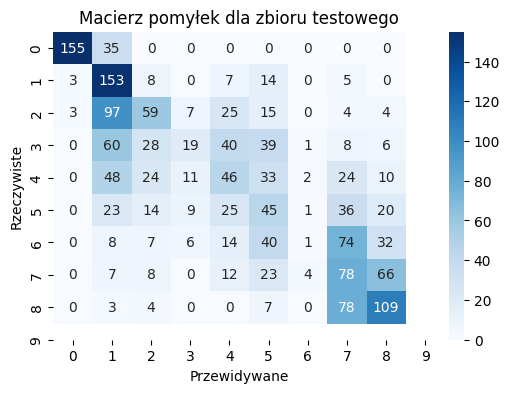

In [125]:
y_pred_2 = model_for_scale.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_2)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek dla zbioru testowego')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

Model analizy skali depresji na zbiorze testowym działa równie dobrze jak na walidacyjnym

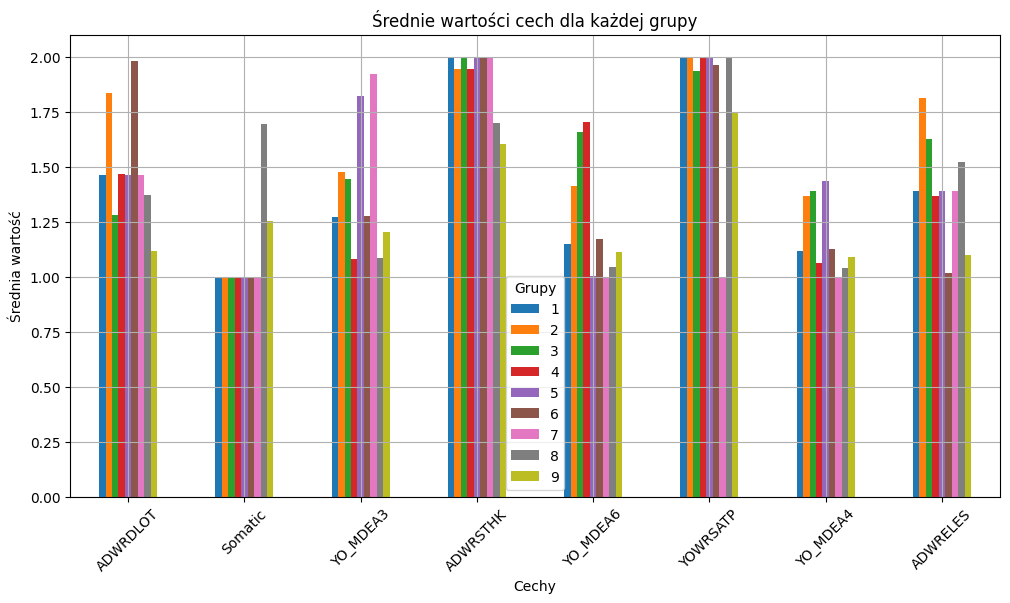

In [127]:
X_test.drop(columns='label', inplace=True)
X_test['label2'] = y_pred_2
groups = X_test.groupby('label2')
mean_features = groups.mean()

mean_features.T.plot(kind='bar', figsize=(12, 6))
plt.title('Średnie wartości cech dla każdej grupy')
plt.xlabel('Cechy')
plt.ylabel('Średnia wartość')
plt.xticks(rotation=45)
plt.legend(title='Grupy')
plt.grid(True)
plt.show()

Co ciekawe analiza przewidywanych grup nie daje nam już tak dobrych wyników jak wcześniej

In [64]:
print("Średnie wartości cech dla każdej grupy:")
print(mean_features)


Średnie wartości cech dla każdej grupy:
       ADWRDLOT   Somatic  YO_MDEA3  ADWRSTHK  YO_MDEA6  YOWRSATP  YO_MDEA4  \
label                                                                         
1      1.516853  1.000000  1.325913  2.000000  1.211956  2.000000  1.182191   
2      1.713943  1.000000  1.542779  1.940758  1.500533  2.000000  1.438888   
3      1.621755  1.000000  1.475543  1.979508  1.451675  1.968033  1.419807   
4      1.645368  1.020292  1.433350  1.931006  1.315161  1.974026  1.217569   
5      1.577938  1.064673  1.447180  1.898949  1.230708  1.988682  1.198858   
6      1.577370  1.169464  1.321397  1.878497  1.174950  1.956035  1.129061   
7      1.487662  1.274336  1.269199  1.823813  1.112085  1.941271  1.092743   
8      1.402906  1.376198  1.205400  1.734026  1.089197  1.894569  1.079767   
9      1.256259  1.440800  1.152491  1.606400  1.083736  1.819200  1.065777   

       ADWRELES  
label            
1      1.454464  
2      1.646125  
3      1.534594  
